In [1]:
import math
import numpy as np

import torch
import torchvision.datasets as datasets
import torchvision.transforms as v2

import torch.nn as nn

from tqdm import tqdm

In [2]:
SINGULAR_VALUE_MEDIAN_THR = 2.58

def beta_thr(beta):
    return 0.56 * np.power(beta, 3) - 0.95 * np.power(beta, 2) + 1.82 * beta + 1.43

SINGULAR_VALUE_BETA_THR = beta_thr

In [3]:
def _detect_knee_point(values, indices):
    """Find elbow point.The elbow cut method is a method to determine a point in
    a curve where significant change can be observed, e.g., from a steep slope to almost flat curve"""
    n_points = len(values)  # number_of_channels
    # coordinate of each channel projected in chosen centroid
    all_coords = np.vstack((range(n_points), values)).T
    first_point = all_coords[0]
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec ** 2))
    vec_from_first = all_coords - first_point  # line coord from first point to last
    scalar_prod = np.sum(
        vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    # "angle" between each point and line
    vec_from_first_parallel = np.outer(scalar_prod, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    # find distance from all points to line
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    knee_idx = np.argmax(dist_to_line)
    knee = values[knee_idx]
    best_dims = [idx for (elem, idx) in zip(values, indices) if elem > knee]
    if len(best_dims) == 0:
        return [knee_idx], knee_idx

    return best_dims,


def sv_to_explained_variance_ratio(singular_values, dispersion_by_component):
    """Calculate the explained variance ratio of the singular values.

    Args:
        singular_values (array-like, shape (n_components,)): Singular values.
        rank (int): Number of singular values to use.

    Returns:
        explained_variance (int): Explained variance percent.
        n_components (int): Number of singular values to use.

    """
    singular_values = [abs(x) for x in singular_values]
    n_components = [x / sum(singular_values) * 100 for x in singular_values]
    n_components = [x for x in n_components if x > dispersion_by_component]
    explained_variance = sum(n_components)
    n_components = len(n_components)
    return explained_variance, n_components


def singular_value_hard_threshold(singular_values,
                                  rank=None,
                                  beta=None,
                                  threshold=SINGULAR_VALUE_MEDIAN_THR) -> list:
    """Calculate the hard threshold for the singular values.

    Args:
        singular_values (array-like, shape (n_components,)): Singular values.
        rank (int): Number of singular values to use.
        beta (float): Beta value.
        threshold (float): Threshold value.

    Returns:
        adjusted singular values array (array-like, shape (n_components,)): Adjusted array of singular values.

    """
    if rank is not None:
        return singular_values[:rank]
    else:
        # Find the median of the singular values
        singular_values = [s_val for s_val in singular_values if s_val > 0.01]
        if len(singular_values) == 1:
            return singular_values[:1]
        median_sv = np.median(singular_values[:rank])
        # Find the adjusted rank
        if threshold is None:
            threshold = SINGULAR_VALUE_BETA_THR(beta)
        sv_threshold = threshold * median_sv
        # Find the threshold value
        adjusted_rank = np.sum(singular_values >= sv_threshold)
        # If the adjusted rank is 0, recalculate the threshold value
        if adjusted_rank == 0:
            sv_threshold = 2.31 * median_sv
            adjusted_rank = max(np.sum(singular_values >= sv_threshold), 1)
        return singular_values[:adjusted_rank]

In [4]:
class RSVDDecomposition:
    def __init__(self, rank: int = None):
        self.rank = rank

    def _init_random_params(self, tensor):
        # Percent of sampling columns. By default - 70%
        projection_rank = math.ceil(min(tensor.shape) / 1.5)
        # Polynom degree for power iteration procedure.
        self.poly_deg = 3
        # Create random matrix for projection/
        self.random_projection = np.random.randn(
            tensor.shape[1], projection_rank)

    def _compute_matrix_approximation(self, Ut, block, tensor, rank):
        Ut_ = Ut[:, :rank]
        tensor_approx = block @ Ut_
        reconstr_m = tensor_approx @ tensor_approx.T @ tensor
        return reconstr_m

    def _spectrum_regularization(self,
                                 spectrum: np.array,
                                 reg_type: str = 'hard_thresholding'):
        if reg_type == 'explained_dispersion':
            low_rank = sv_to_explained_variance_ratio(spectrum, 3)[1]
        elif reg_type == 'hard_thresholding':
            low_rank = len(singular_value_hard_threshold(spectrum))
        return max(low_rank, 2)

    def _matrix_approx_regularization(self, low_rank, Ut, block, tensor):
        if low_rank == 1:
            return low_rank
        else:
            list_of_rank = list(range(1, low_rank + 1, 1))
            reconstr_matrix = [self._compute_matrix_approximation(
                Ut, block, tensor, rank) for rank in list_of_rank]
            fro_norms = [abs(np.linalg.norm(tensor - reconstr_m, 'fro') / np.linalg.norm(tensor) * 100)
                         for reconstr_m in reconstr_matrix]
            regularized_rank = _detect_knee_point(
                values=fro_norms, indices=list(range(len(fro_norms))))
            regularized_rank = len(regularized_rank)
            # deriviate_of_error = abs(np.diff(fro_norms))
            # regularized_rank = len(
            #     deriviate_of_error[deriviate_of_error > 1]) + 1
        return regularized_rank

    def rsvd_and_rank(self,
             tensor: np.array,
             approximation: bool = False,
             regularized_rank: int = None,
             reg_type: str = 'hard_thresholding') -> tuple[list, int]:
        """Block Krylov subspace method for computing the SVD of a matrix with a low computational cost.

        Args:
            tensor: matrix to decompose
            approximation: if True, the matrix approximation will be computed
            regularized_rank: rank of the matrix approximation
            reg_type: type of regularization. 'hard_thresholding' or 'explained_dispersion'

        Returns:
            u, s, vt: decomposition
            rank recommended approximated_rank
        """
        # Return classic svd decomposition with chosen type of spectrum thresholding
        if not approximation:
            # classic svd decomposition
            Ut, St, Vt = np.linalg.svd(tensor, full_matrices=False)
            # Compute low rank.
            low_rank = self._spectrum_regularization(St, reg_type=reg_type)
            if regularized_rank is not None:
                low_rank = regularized_rank
            # Return first n eigen components.
            U_, S_, V_ = Ut[:, :low_rank], St[:low_rank], Vt[:low_rank, :]

            print(f"Recommended rank {low_rank}±")

            return [U_, S_, V_], low_rank
        else:
            # First step. Initialize random matrix params.
            self._init_random_params(tensor)
            # Second step. Transform initial matrix to Gram. matrix
            AAT = tensor @ tensor.T
            # Third step. Power iteration procedure. First we raise the Gram matrix to the chosen degree.
            # This step is necessary in order to obtain a more "pronounced" spectrum
            # (in which the eigenvalues are well separated from each other).
            # The important point is that the exponentiation procedure only changes
            # the eigenvalues but does not change the eigenvectors. Next, the resulting matrix is multiplied with the
            # original matrix ("overweighing" the column space) and then multiplied with a random matrix
            # in order to reduce the dimension and facilitate the procedure for "large" matrices.
            sampled_tensor = np.linalg.matrix_power(
                AAT, self.poly_deg) @ tensor @ self.random_projection
            # Fourth step. Orthogonalization of the resulting "sampled" matrix creates for us a basis of eigenvectors.
            sampled_tensor_orto, _ = np.linalg.qr(
                sampled_tensor, mode='reduced')
            # Fifth step. Project initial Gramm matrix on new basis obtained from "sampled matrix".
            M = sampled_tensor_orto.T @ AAT @ sampled_tensor_orto
            # Six step. Classical svd decomposition with choosen type of spectrum thresholding
            Ut, St, Vt = np.linalg.svd(M, full_matrices=False)
            # Compute low rank.
            low_rank = self._spectrum_regularization(St, reg_type=reg_type)
            # Seven step. Compute matrix approximation and choose new low_rank
            if regularized_rank is None:
                regularized_rank = self._matrix_approx_regularization(
                    low_rank, Ut, sampled_tensor_orto, tensor)
            # Eight step. Return matrix approximation.
            reconstr_tensor = self._compute_matrix_approximation(
                Ut, sampled_tensor_orto, tensor, regularized_rank)
            U_, S_, V_ = np.linalg.svd(reconstr_tensor, full_matrices=False)

            print(f"Recommended rank {regularized_rank}")

            return [U_, S_, V_,], regularized_rank

In [5]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize((0.1307,), (0.3081,))
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
class DummyOverComplicatedNeuralNetwork(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(DummyOverComplicatedNeuralNetwork,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28) # .to(torch.float32)
        x = self.relu(self.linear1(x)) # .to(torch.float32)
        x = self.relu(self.linear2(x)) #.to(torch.float32)
        x = self.linear3(x) # .to(torch.float32)
        return x

docnn_model = DummyOverComplicatedNeuralNetwork().to(device)

In [7]:
def train(train_loader, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x.view(-1, 28*28))
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return

train(train_loader, docnn_model, epochs=1)

Epoch 1: 100%|██████████| 6000/6000 [00:29<00:00, 200.47it/s, loss=0.24] 


In [8]:
weights_to_rsvd = {}

for name, param in docnn_model.named_parameters():
    weights_to_rsvd[name] = param.clone().detach()

In [9]:
def test():
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = docnn_model(x.view(-1, 784))

            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1

    print(f"Accuracy: {round(correct/total, 3)}")

    for i in range(len(wrong_counts)):
        print(f"Incorrect counts for {i}: {wrong_counts[i]}")

test()

Testing: 100%|██████████| 1000/1000 [00:03<00:00, 310.93it/s]

Accuracy: 0.967
Incorrect counts for 0: 8
Incorrect counts for 1: 10
Incorrect counts for 2: 54
Incorrect counts for 3: 32
Incorrect counts for 4: 48
Incorrect counts for 5: 29
Incorrect counts for 6: 31
Incorrect counts for 7: 27
Incorrect counts for 8: 46
Incorrect counts for 9: 48


In [10]:
# Size of the weights matrices of the network
# and save total number of parameters
total_parameters_original = 0

for index, layer in enumerate([docnn_model.linear1, docnn_model.linear2, docnn_model.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()

    print(f"Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}")

print(f"Total number of parameters: {total_parameters_original:,}")

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010



### RSVD Decomposition method

 Get $U, S, V$ matricies and reccomended rank for each layer

In [11]:
rsvd = RSVDDecomposition()

In [12]:
usv1, rank = rsvd.rsvd_and_rank(
    tensor=weights_to_rsvd["linear1.weight"].cpu().detach().numpy(),
    approximation=True,
)

Recommended rank 1


In [13]:
usv2, rank2 = rsvd.rsvd_and_rank(
    tensor=weights_to_rsvd["linear2.weight"].cpu().detach().numpy(),
    approximation=True,
)

Recommended rank 1


In [14]:
usv3, rank3 = rsvd.rsvd_and_rank(
    tensor=weights_to_rsvd["linear3.weight"].cpu().detach().numpy(),
    approximation=True,
)

Recommended rank 2


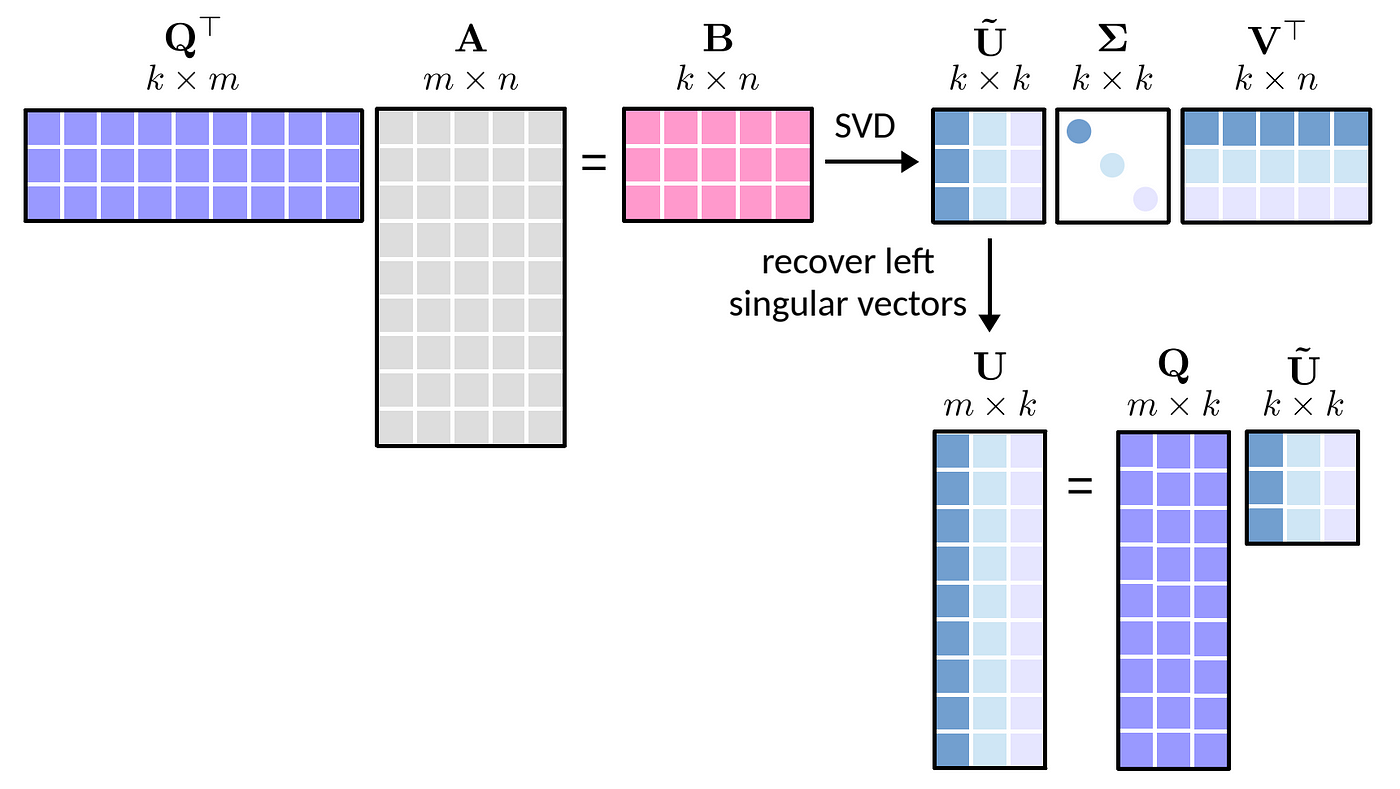)

### Modified `LoRAParametrization()` from [Lora Implementation - Collab](https://drive.google.com/file/d/1O4GGzD1WTwnuxECxh1dhmC-sYCNYEs3v/view?usp=sharing)

So now it uses info from RSVD as init of matricies A & B

In [24]:
usv1[0][:1,:] @ usv1[1][:1]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 784)

In [31]:
class LoRAParametrizationWithInfo(nn.Module):
    def __init__(self, USV, rank=1, alpha=1, device='cpu'):
        super().__init__()
        # Section 4.1 of the paper:
        #   We use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training
        # In previous series:
        # - A = torch.zeros((rank, features_out))
        # - B = torch.zeros((features_in, rank))
        self.USV = USV
        self.rank = rank
        self._a = torch.tensor(self.USV[1][:self.rank] @ self.USV[2][:,:self.rank].T)  # torch.from_numpy(USV[1]) @ torch.from_numpy(USV[2])
        self._b = torch.tensor(self.USV[0][:self.rank,:].T @ self.USV[1][:self.rank])
        self.USV = USV


        self.lora_A = nn.Parameter(torch.unsqueeze(self._a, 0)).to(device)
        self.lora_B = nn.Parameter(torch.unsqueeze(self._b, 1)).to(device)

        nn.init.normal_(self.lora_A, mean=0, std=1)

        # Section 4.1 of the paper:
        #   We then scale ∆Wx by α/r , where α is a constant in r.
        #   When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately.
        #   As a result, we simply set α to the first r we try and do not tune it.
        #   This scaling helps to reduce the need to retune hyperparameters when we vary r.
        self.scale = alpha / rank
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B * A) * scale

            #original_weights = self._a @ self._b
            return (original_weights + torch.matmul(self.lora_B, self.lora_A).view(original_weights.shape) * self.scale).to(torch.float32)
        else:
            return original_weights

> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/example.svg">
>   <img alt="Example" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/example.svg">
> </picture><br>
>
> ### Check original in|out features & weights after matricies multiplication

In [32]:
print(f"                  in,  out")
print(f"L1 : {docnn_model.linear1.weight.shape}")
print(f"L2 : {docnn_model.linear2.weight.shape}")
print(f"L3 : {docnn_model.linear3.weight.shape}")

                  in,  out
L1 : torch.Size([1000, 784])
L2 : torch.Size([2000, 1000])
L3 : torch.Size([10, 2000])


In [33]:
import torch.nn.utils.parametrize as parametrize

def linear_layer_parameterization_with_info(USV, device, rank=1, lora_alpha=1):
    # Only add the parameterization to the weight matrix, ignore the Bias

    # From section 4.2 of the paper:
    #   We limit our study to only adapting the attention weights for downstream tasks and freeze the MLP modules (so they are not trained in downstream tasks) both for simplicity and parameter-efficiency.
    #   [...]
    #   We leave the empirical investigation of [...], and biases to a future work.

    return LoRAParametrizationWithInfo(USV, rank=rank, alpha=lora_alpha, device=device)

parametrize.register_parametrization(
    docnn_model.linear1,
    "weight",
    linear_layer_parameterization_with_info(usv1, device, rank),

)

parametrize.register_parametrization(
    docnn_model.linear2,
    "weight",
    linear_layer_parameterization_with_info(usv2, device, rank2),
)

parametrize.register_parametrization(
    docnn_model.linear3,
    "weight",
    linear_layer_parameterization_with_info(usv3, device, rank3),
)


def enable_disable_lora(enabled=True):
    for layer in [docnn_model.linear1, docnn_model.linear2, docnn_model.linear3]:
        layer.parametrizations["weight"][0].enabled = enabled

RuntimeError: shape '[1000, 784]' is invalid for input of size 614656

In [178]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([docnn_model.linear1, docnn_model.linear2, docnn_model.linear3]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()

    print(f"Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations['weight'][0].lora_A.shape} + Lora_B: {layer.parametrizations['weight'][0].lora_B.shape}")

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([1000, 1])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([1, 1000]) + Lora_B: torch.Size([2000, 1])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 2000]) + Lora_B: torch.Size([10, 1])


In [180]:
# Freeze the non-Lora parameters
for name, param in docnn_model.named_parameters():
    if "lora" not in name:
        print(f"Freezing non-LoRA parameter {name}")
        param.requires_grad = False

mnist_trainset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Train the network with LoRA only on the digit 9 and only for 100 batches (hoping that it would improve the performance on the digit 9)
train(train_loader, docnn_model, epochs=1, total_iterations_limit=100)

Freezing non-LoRA parameter linear1.bias
Freezing non-LoRA parameter linear1.parametrizations.weight.original
Freezing non-LoRA parameter linear2.bias
Freezing non-LoRA parameter linear2.parametrizations.weight.original
Freezing non-LoRA parameter linear3.bias
Freezing non-LoRA parameter linear3.parametrizations.weight.original


Epoch 1:  99%|█████████▉| 99/100 [00:06<00:00, 15.50it/s, loss=104]


> <picture>
>   <source media="(prefers-color-scheme: light)" srcset="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/light-theme/issue.svg">
>   <img alt="Issue" src="https://raw.githubusercontent.com/Mqxx/GitHub-Markdown/main/blockquotes/badge/dark-theme/issue.svg">
> </picture><br>
>
> After using info from lora parametrization prediction sucks

In [181]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test()

Testing: 100%|██████████| 1000/1000 [00:35<00:00, 27.85it/s]

Accuracy: 0.394
Incorrect counts for 0: 808
Incorrect counts for 1: 718
Incorrect counts for 2: 426
Incorrect counts for 3: 824
Incorrect counts for 4: 338
Incorrect counts for 5: 574
Incorrect counts for 6: 840
Incorrect counts for 7: 592
Incorrect counts for 8: 502
Incorrect counts for 9: 443


In [182]:
# Test with LoRA enabled
enable_disable_lora(enabled=False)
test()

Testing: 100%|██████████| 1000/1000 [00:08<00:00, 119.34it/s]

Accuracy: 0.96
Incorrect counts for 0: 19
Incorrect counts for 1: 11
Incorrect counts for 2: 21
Incorrect counts for 3: 57
Incorrect counts for 4: 30
Incorrect counts for 5: 53
Incorrect counts for 6: 41
Incorrect counts for 7: 24
Incorrect counts for 8: 77
Incorrect counts for 9: 69
